# Análisis ML en Sure Tomorrow

# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.

- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MaxAbsScaler

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [4]:
df = pd.read_csv('insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [5]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [6]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
857,1,23.0,43400.0,1,0
3241,1,26.0,45700.0,1,0
372,0,37.0,33700.0,1,0
2293,0,30.0,42400.0,0,0
4332,0,28.0,49500.0,3,0
4234,0,29.0,38900.0,1,0
4919,1,34.0,48500.0,3,0
4045,1,32.0,53700.0,2,0
4602,1,23.0,35300.0,1,0
1295,0,37.0,30400.0,0,0


In [7]:
#Hacemos un análisis exploratorio de los datos
display(df.describe())
print()
#Buscamos valores faltantes
print(df.isna().sum())
print()
#Buscamos valores duplicados
print(df.duplicated().sum())

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000



gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

153


In [8]:
#Revisamos ejemplos de los duplicados
print(df[df.duplicated()].head())
#eliminamos duplicado
df = df.drop_duplicates().reset_index(drop=True)

     gender   age   income  family_members  insurance_benefits
281       1  39.0  48100.0               1                   0
488       1  24.0  32900.0               1                   0
513       0  31.0  37400.0               2                   0
718       1  22.0  32600.0               1                   0
785       0  20.0  35800.0               0                   0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4847 non-null   int64  
 1   age                 4847 non-null   float64
 2   income              4847 non-null   float64
 3   family_members      4847 non-null   int64  
 4   insurance_benefits  4847 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 189.5 KB


In [10]:
# Convertimos tipos de datos:
df["income"] = df["income"].astype("int64")
df["age"] = df["age"].astype("int64")

In [11]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gender              4847 non-null   int64
 1   age                 4847 non-null   int64
 2   income              4847 non-null   int64
 3   family_members      4847 non-null   int64
 4   insurance_benefits  4847 non-null   int64
dtypes: int64(5)
memory usage: 189.5 KB


## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

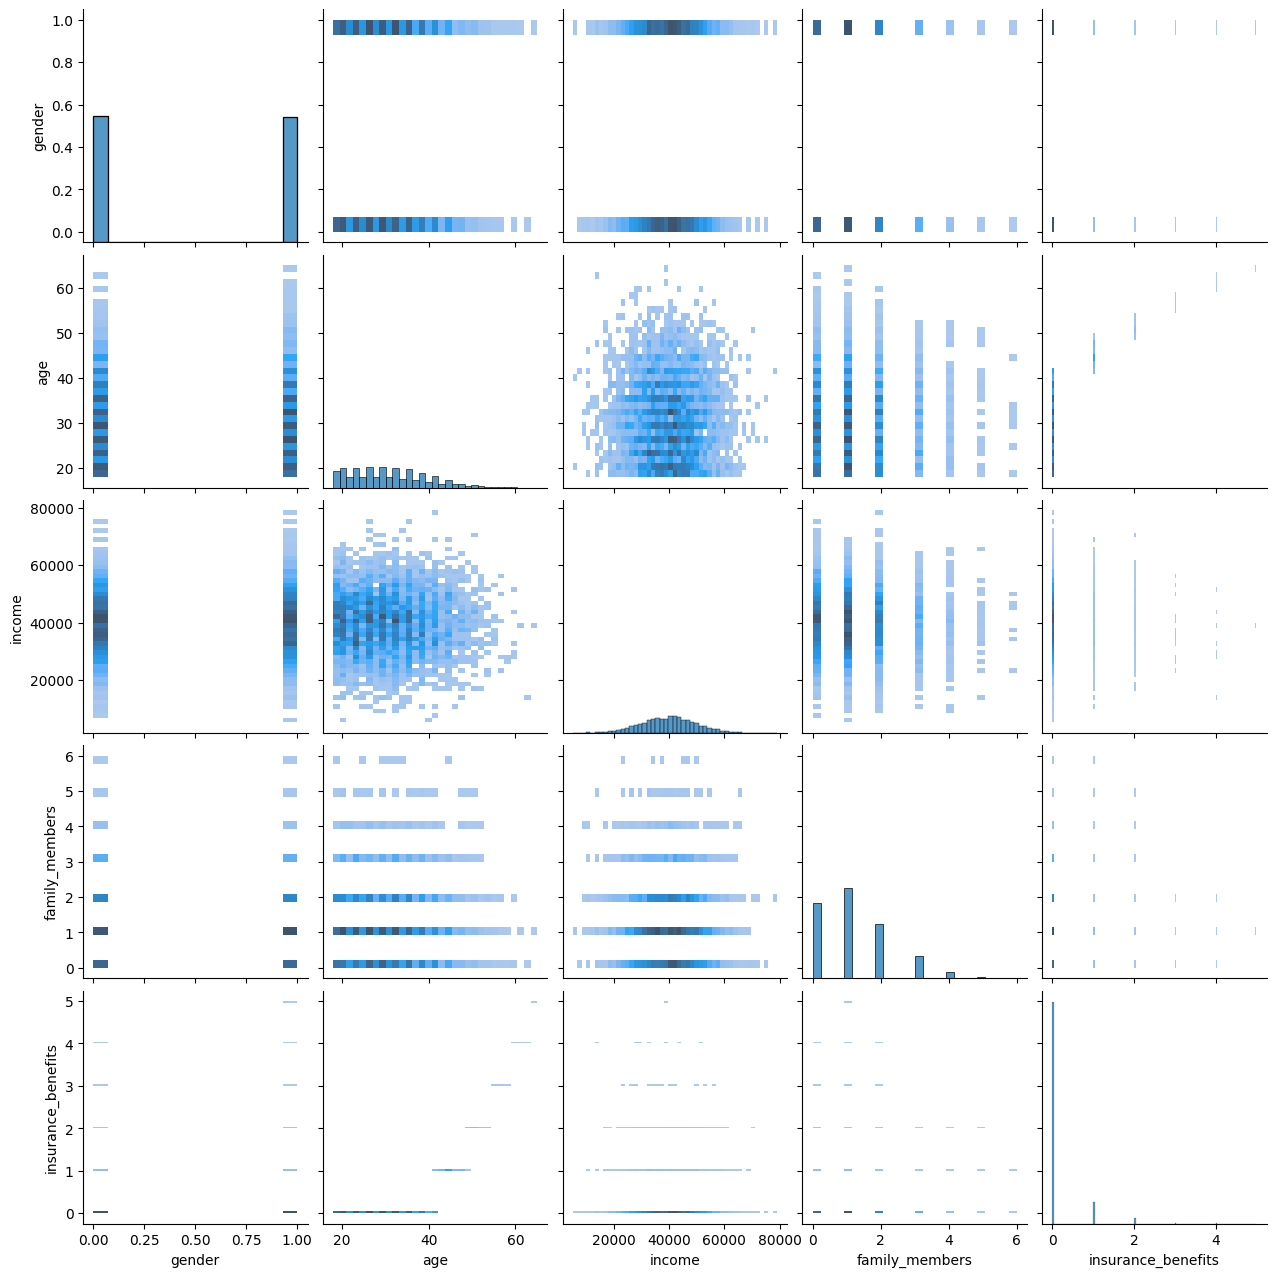

In [12]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(13, 13)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.

Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)
- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.

Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.

Pruébalo para cuatro combinaciones de dos casos
- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:
- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?
- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [14]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar
    :param n: número de objetos para los que se buscan los vecinos más cercanos
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia
    """
    X = df[feature_names].values
    nbrs = NearestNeighbors(n_neighbors=k+1, metric = metric)
    nbrs.fit(X)
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([X[n]])

    #Excluimos el mismo punto n como primer vecino
    distances = nbrs_distances[0][1:]
    indices = nbrs_indices[0][1:]
    
    df_res = pd.concat([df.iloc[indices].reset_index(drop=True), pd.DataFrame({'distance':distances})], axis=1)
    
    return df_res

Escalar datos.

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

/var/folders/7c/xbc29f0j14q03hvxtr3z9cvm0000gn/T/ipykernel_2213/760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63076923 0.70769231 0.44615385 ... 0.30769231 0.33846154 0.43076923]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())
/var/folders/7c/xbc29f0j14q03hvxtr3z9cvm0000gn/T/ipykernel_2213/760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.6278481  0.48101266 0.26582278 ... 0.42911392 0.41392405 0.51392405]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())
/var/folders/7c/xbc29f0j14q03hvxtr3z9cvm0000gn/T/ipykernel_2213/760832288.py:6: FutureWarning: Setti

In [16]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3928,1,0.492308,0.679747,0.333333,0
1408,0,0.630769,0.555696,0.333333,0
3716,1,0.569231,0.413924,0.333333,0
1620,0,0.476923,0.394937,0.333333,0
3293,1,0.584615,0.400000,0.166667,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [17]:
#Metrica Euclideana
get_knn(df, n=100, k=5, metric='euclidean')  # datos sin escalar

,gender,age,income,family_members,insurance_benefits,distance
0,1,19,37300,0,0,1.414214
1,0,20,37300,2,0,1.414214
2,1,19,37300,2,0,1.414214
3,0,22,37300,3,0,3.605551
4,1,23,37300,0,0,4.242641


In [18]:
get_knn(df_scaled, n=100, k=5, metric='euclidean')  # datos con escalado

,gender,age,income,family_members,insurance_benefits,distance
0,0,0.292308,0.477215,0.166667,0,0.005063
1,0,0.292308,0.467089,0.166667,0,0.005063
2,0,0.292308,0.456962,0.166667,0,0.015190
3,0,0.307692,0.470886,0.166667,0,0.015437
4,0,0.307692,0.469620,0.166667,0,0.015592


In [19]:
#Metrica Manhattan
get_knn(df, n=100, k=5, metric='manhattan')  # datos sin escalar

,gender,age,income,family_members,insurance_benefits,distance
0,0,20,37300,2,0,2.0
1,1,19,37300,2,0,2.0
2,1,19,37300,0,0,2.0
3,0,22,37300,3,0,5.0
4,1,23,37300,0,0,6.0


In [20]:
get_knn(df_scaled, n=100, k=5, metric='manhattan')  # datos con escalado

,gender,age,income,family_members,insurance_benefits,distance
0,0,0.292308,0.477215,0.166667,0,0.005063
1,0,0.292308,0.467089,0.166667,0,0.005063
2,0,0.292308,0.456962,0.166667,0,0.015190
3,0,0.307692,0.470886,0.166667,0,0.016650
4,0,0.307692,0.469620,0.166667,0,0.017916


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Sí afecta, ya que al no escalar los datos, estos tienen métricas distintas; por lo tanto, tienen pesos diferentes al momento en que el algoritmo los evalúa.

Debido a que algunas variables tienen valores mucho más grandes —como es el caso de income—, esta variable termina dominando la elección del k-ésimo vecino, haciendo que los vecinos seleccionados siempre sean similares en income, pero no necesariamente en otras variables importantes como gender o family_members.

Esto puede afectar la calidad del modelo, ya que se pierde información valiosa que también debería influir en la predicción o comparación entre registros.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

En general los resultados son similares en ambas métricas. Se pueden nortar pequeñas diferencias en los vecinos seleccionados debido a sus diferencias metodológicas (valor absoluto en Manhattan y raiz cuadrada en Euclideana).

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.

Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.
- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.

La probabilidad de pagar cualquier prestación del seguro puede definirse como

$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [21]:
# сalcula el objetivo

df['insurance_benefits_received'] = (df['insurance_benefits']>0).astype(int)

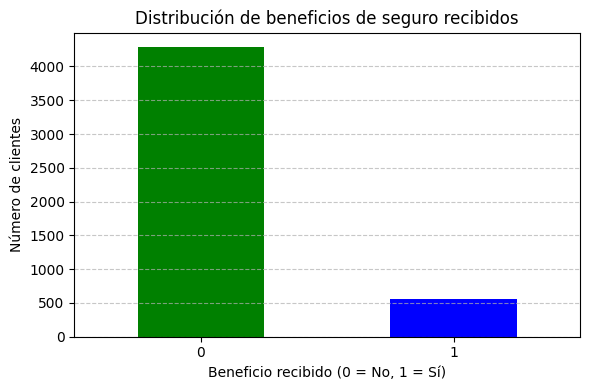

insurance_benefits_received
0    4284
1     563
Name: count, dtype: int64

In [22]:
# comprueba el desequilibrio de clases con value_counts()

class_counts = df['insurance_benefits_received'].value_counts()
plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color=['green', 'blue'])
plt.title('Distribución de beneficios de seguro recibidos')
plt.xlabel('Beneficio recibido (0 = No, 1 = Sí)')
plt.ylabel('Número de clientes')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print()
display(class_counts)

In [23]:
#Definimos variables
features = ['gender', 'age', 'income', 'family_members']
target = 'insurance_benefits_received'
X = df[features]
y = df[target]
#Escalamos datos
X_scaled = sklearn.preprocessing.MaxAbsScaler().fit_transform(X)
#Separamos el conjunto de datos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)
#Lo mismo para el conjunto de datos escalados
X_train_scaled, X_test_scaled = train_test_split(
    X_scaled, test_size=0.3, random_state=1, stratify=y
)

In [24]:
#Creamos el clasificador KNN de K=1 a 10 para datos originales
print("F1 scores para kNN con datos originales:")
for k in range(1, 11):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred)
    print(f"k={k}, F1 = {score:.3f}")

F1 scores para kNN con datos originales:
k=1, F1 = 0.653
k=2, F1 = 0.350
k=3, F1 = 0.377
k=4, F1 = 0.169
k=5, F1 = 0.197
k=6, F1 = 0.045
k=7, F1 = 0.056
k=8, F1 = 0.035
k=9, F1 = 0.046
k=10, F1 = 0.035


In [25]:
#Creamos el clasificador KNN de K=1 a 10 para datos escalados
print("F1 scores para kNN con datos escalados:")
for k in range(1, 11):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    score = f1_score(y_test, y_pred)
    print(f"k={k}, F1 = {score:.3f}")

F1 scores para kNN con datos escalados:
k=1, F1 = 0.961
k=2, F1 = 0.927
k=3, F1 = 0.933
k=4, F1 = 0.915
k=5, F1 = 0.931
k=6, F1 = 0.916
k=7, F1 = 0.924
k=8, F1 = 0.922
k=9, F1 = 0.930
k=10, F1 = 0.918


In [26]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [27]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [28]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(y_test))
        
    eval_classifier(y_test, y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8838488 0.       ]
 [0.1161512 0.       ]]

La probabilidad: 0.12
F1: 0.12
Matriz de confusión
[[0.77731959 0.10652921]
 [0.1024055  0.0137457 ]]

La probabilidad: 0.50
F1: 0.17
Matriz de confusión
[[0.44123711 0.44261168]
 [0.06323024 0.05292096]]

La probabilidad: 1.00
F1: 0.21
Matriz de confusión
[[0.        0.8838488]
 [0.        0.1161512]]



# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos
- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades
- $y$ — objetivo (un vector)
- $\hat{y}$ — objetivo estimado (un vector)
- $w$ — vector de pesos

La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:

$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
    
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos

$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [29]:
class MyLinearRegression:
    
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        X2 = np.hstack([np.ones((X.shape[0], 1)), X])  # columna de unos
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        X2 = np.hstack([np.ones((X.shape[0], 1)), X])  # columna de unos
        return X2 @ self.weights

        

In [30]:
def eval_regressor(y_true, y_pred):
    
    rmse = (sklearn.metrics.mean_squared_error(y_true, y_pred))**0.5
    print(f'RMSE: {rmse:.2f}')
    
    r2 = r2_score(y_true, y_pred)
    print(f'R2: {r2:.2f}')    

In [31]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()
coef = ['Intercepto (w₀)', 'Edad', 'Género', 'Ingreso', 'Miembros de familia']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

lr = MyLinearRegression()

lr.fit(X_train, y_train)

coef_table_0 = pd.DataFrame({
    'Variable': coef,
    'Coeficiente': lr.weights
})
print("Pesos originales:")
print()
display(coef_table_0)
y_test_pred = lr.predict(X_test)


print("Evaluación en datos originales:")
eval_regressor(y_test, y_test_pred)

Pesos originales:



,Variable,Coeficiente
0,Intercepto (w₀),-9.216314e-01
1,Edad,3.553325e-02
2,Género,8.766005e-04
3,Ingreso,-4.341802e-07
4,Miembros de familia,-1.585173e-02


Evaluación en datos originales:
RMSE: 0.36
R2: 0.45


In [32]:
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_scaled, y, test_size=0.3, random_state=1
)

lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_s, y_train_s)

coef_table_1 = pd.DataFrame({
    'Variable': coef,
    'Coeficiente': lr_scaled.weights
})

print("Pesos escalados:")
print()
display(coef_table_1)

y_test_pred_s = lr_scaled.predict(X_test_s)
print("Evaluación en datos escalados:")
eval_regressor(y_test_s, y_test_pred_s)

Pesos escalados:



,Variable,Coeficiente
0,Intercepto (w₀),-0.921631
1,Edad,2.309661
2,Género,0.000877
3,Ingreso,-0.034300
4,Miembros de familia,-0.095110


Evaluación en datos escalados:
RMSE: 0.36
R2: 0.45


**¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?**

El escalado de los datos no afecta la calidad de las predicciones del modelo, pero sí hace que los coeficientes resultantes sean más legibles y comparables. 

Aunque los valores de RMSE y R² se mantuvieron iguales entre el modelo original y el modelo escalado, los coeficientes del modelo escalado fueron más fáciles de interpretar y comparar entre ellos debido a que se colocaron en la misma escala.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [33]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [34]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [35]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [36]:
#Una matriz es invertible si y solo si su determinante es distinto de cero
if np.linalg.det(P) != 0:
    print('La matriz P es invertible')
else:
    print('La matriz P no es invertible')

La matriz P es invertible


In [37]:
#Ofuscamos los datos
X_of = X @ P

¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

In [38]:
print("Datos originales (primeras 5 filas):")
print(pd.DataFrame(X[:5], columns = personal_info_column_list))

print("\nDatos ofuscados (primeras 5 filas):")
print(pd.DataFrame(X_of[:5], columns = personal_info_column_list))
print()
print("Los datos transformados ya no revelan información personal de los clientes de la aseguradora")

Datos originales (primeras 5 filas):
   gender  age  income  family_members
0       1   41   49600               1
1       0   46   38000               1
2       0   29   21000               0
3       0   21   41700               2
4       1   28   26100               0

Datos ofuscados (primeras 5 filas):
        gender           age        income  family_members
0  6359.715273  22380.404676  18424.090742    46000.696690
1  4873.294065  17160.367030  14125.780761    35253.455773
2  2693.117429   9486.397744   7808.831560    19484.860631
3  5345.603937  18803.227203  15479.148373    38663.061863
4  3347.176735  11782.829283   9699.998942    24211.273378

Los datos transformados ya no revelan información personal de los clientes de la aseguradora


¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [39]:
#Para recuperar los datos se debe utiliar la matriz inversa de P
P_inv = np.linalg.inv(P)
X_rec = X_of @ P_inv
#Probamos si nos devuelve a la matriz con los datos originales
if np.allclose(X, X_rec):
    print('Los datos originales se restauraron')
else:
    print('Los datos no se restauraron')

Los datos originales se restauraron


Muestra los tres casos para algunos clientes
- Datos originales
- El que está transformado
- El que está invertido (recuperado)

In [40]:
random_client = np.random.choice(X.shape[0], size = 5, replace = False)
titles = ['Datos originales', 'Datos ofuscados', 'Datos recuperados']
matrix = [X, X_of, X_rec]
for title, m in zip(titles, matrix):
    print(f"\n {title}")
    display(pd.DataFrame(m[random_client], columns = personal_info_column_list))



 Datos originales


,gender,age,income,family_members
0,0,26,42400,1
1,1,21,34100,0
2,1,38,45700,1
3,0,35,48800,0
4,0,32,36300,0



 Datos ofuscados


,gender,age,income,family_members
0,5435.110502,19122.552710,15742.069274,39315.500438
1,4371.426555,15379.087430,12661.055158,31619.890838
2,5859.789574,20620.972651,16975.695028,42383.955041
3,6255.241482,22012.980552,18121.583472,45253.643706
4,4653.538541,16380.229461,13484.324750,33666.723153



 Datos recuperados


,gender,age,income,family_members
0,-1.897453e-12,26.0,42400.0,1.000000e+00
1,1.000000e+00,21.0,34100.0,4.216226e-13
2,1.000000e+00,38.0,45700.0,1.000000e+00
3,9.051813e-13,35.0,48800.0,3.283934e-12
4,2.393993e-12,32.0,36300.0,-2.547681e-12


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Es posible observar pequeñas diferencias entre los valores originales [X] y los recuperados [X_rec]. Esto se debe a imprecisiones numéricas en las operaciones de multiplicación de matrices.

Al realizar la transformación X_of = X @ P y luego la recuperación X_rec = X' @ P_inv, los cálculos implican multiplicaciones y una inversión de matriz, que pueden acumular errores decimales muy pequeños.

Estas diferencias son mínimas y no afectan significativamente los datos ni los resultados de los modelos de machine learning.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?

Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

### **¿Cómo se relacionarían \( w \) y \( w_P \) si simplificáramos la fórmula de \( w_P \) anterior?**

Desarrollando la fórmula:  
$$
w_P = \left( (X P)^T (X P) \right)^{-1} (X P)^T y
$$

Desarrollo paso a paso:

$$
w_P = \left( P^T X^T X P \right)^{-1} P^T X^T y
$$

Aplicamos la propiedad de la inversa de matrices:
$$
(P^T X^T X P)^{-1} = P^{-1} (X^T X)^{-1} (P^T)^{-1}
$$

Entonces:
$$
w_P = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$

Como $ (P^T)^{-1} P^T = I $, entonces:
$$
w_P = P^{-1} (X^T X)^{-1} X^T y
$$

Finalmente como $w =(X^T X)^{-1} X^T y $:
$$
\boxed{w_P = P^{-1} w}
$$


**¿Cuáles serían los valores predichos con $w_P$?**

Los valores de los coeficientes de w serán diferentes, debido a que se multiplican por $P^{-1}$. sin embargo los valores predichos son exactamente los mismos que con los datos originales, debido a que si los datos ofuscados $X´ = X P$ y los coeficientes $w_P = P^{-1} w$. 

Entonces:

$\hat{y}= X´w_P = XPP^{-1}w=Xw$

Por lo tanto:

$$
\hat{y}_{\text{ofuscado}} = X' w_P = X w = \hat{y}_{\text{original}}
$$




**¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?**
Dado que los valores predichos con los datos ofuscados son exactamente los mismos que con los datos originales, la calidad del modelo no cambia

El RMSE se calcula como:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$

Como los valores reales $y_i$ y los valores predichos $ \hat{y}_i $ no cambian, el valor de RMSE permanece igual, del mismo modo que el de $R^2$


## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.

Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.

Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.
- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.
- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [41]:
X_of_train, X_of_test, y_train, y_test = train_test_split(X_of, y, test_size=0.3, random_state=1)

lr.fit(X_of_train, y_train)

coef_table_2 = pd.DataFrame({
    'Variable': coef,
    'Coeficiente': lr.weights
})
print("Regresión lineal con ofuscacion de datos:")
print()
display(coef_table_2)
y_test_of_pred = lr.predict(X_of_test)


print("Evaluación de Regresión lineal con ofuscacion de datos:")
eval_regressor(y_test, y_test_of_pred)

Regresión lineal con ofuscacion de datos:



,Variable,Coeficiente
0,Intercepto (w₀),-0.921631
1,Edad,-0.068799
2,Género,-0.003990
3,Ingreso,0.082630
4,Miembros de familia,-0.021611


Evaluación de Regresión lineal con ofuscacion de datos:
RMSE: 0.36
R2: 0.45


In [42]:
print("Regresión lineal con pesos originales:")
print()
display(coef_table_0)
y_test_pred = lr.predict(X_test)


print("Evaluación de Regresión lineal en datos originales:")
eval_regressor(y_test, y_test_pred)

Regresión lineal con pesos originales:



,Variable,Coeficiente
0,Intercepto (w₀),-9.216314e-01
1,Edad,3.553325e-02
2,Género,8.766005e-04
3,Ingreso,-4.341802e-07
4,Miembros de familia,-1.585173e-02


Evaluación de Regresión lineal en datos originales:
RMSE: 3383.96
R2: -48757622.67


Comparación de predicciones:


,Predicción original,Predicción ofuscada
0,2914.225122,-0.115863
1,4103.909224,0.001212
2,3468.190526,-0.296439
3,1576.074150,-0.290326
4,1542.054949,0.208190
5,3062.495259,0.148816
6,1905.330410,0.332561
7,3790.258987,-0.174804
8,2906.396521,-0.313168
9,2079.360732,0.097891


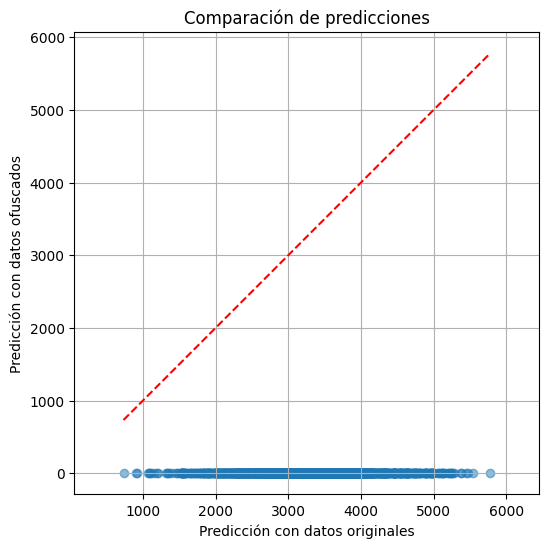

In [43]:
import matplotlib.pyplot as plt
# Comparar predicciones originales vs ofuscadas
comparison_df = pd.DataFrame({
    'Predicción original': y_test_pred,
    'Predicción ofuscada': y_test_of_pred
})

# Mostrar primeros valores
print("Comparación de predicciones:")
display(comparison_df.head(10))

# Gráfico de comparación
plt.figure(figsize=(6, 6))
plt.scatter(y_test_pred, y_test_of_pred, alpha=0.5)
plt.plot([min(y_test_pred), max(y_test_pred)],
         [min(y_test_pred), max(y_test_pred)], color='red', linestyle='--')
plt.xlabel("Predicción con datos originales")
plt.ylabel("Predicción con datos ofuscados")
plt.title("Comparación de predicciones")
plt.grid(True)
plt.axis("equal")
plt.show()


# Conclusiones

Los coeficientes de ambas regresiones son distintos debido a que estan adaptados a los datos ofuscados.

Las predicciones son casi idénticas ya sea si se usan los datos ofuscados u originales.

Los parametros RMSE y $R^2$ se mantienen sin alteraciones manteniuendo la calidad del modelo.

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>